In [1]:
import torch
import numpy as np
from tqdm import tqdm
from utils.SaseFEdatasetFullclas import VideoSaseFEdatasetSingle
from utils.utils import *
import yaml
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device


'cuda'

In [2]:
config_path = "configs/template_train_feature_extractor.yaml"
with open(config_path, "r") as stream:
    config = yaml.safe_load(stream)

# make params accessible by dot notation
params = config["training_params"]
datamodule = config["datamodule"]
num_classes = params["num_classes"]
train_dataset, _ = init_dataset(datamodule["dataset_dir"],datamodule["n_frames"], num_classes, test_size=10)

Loading dataset...
Dataset loaded 0.047003984451293945


In [3]:
anchor_images = []
for A,P,N,label in train_dataset:
    anchor_images.append(A)

In [4]:
int2emo = config["int2emo"]

In [5]:
triplet_train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=False)

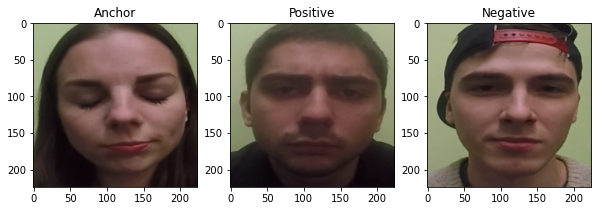

In [6]:
idx = 40
A,P,N,_ = train_dataset[idx]

f, (ax1, ax2, ax3,) = plt.subplots(1,3,figsize= (10,5))

ax1.set_title('Anchor')
ax1.imshow(A.numpy().transpose((1,2,0)), cmap = 'gray')

ax2.set_title('Positive')
ax2.imshow(P.numpy().transpose((1,2,0)), cmap = 'gray')

ax3.set_title('Negative')
ax3.imshow(N.numpy().transpose((1,2,0)), cmap = 'gray')

In [7]:
import pandas as pd
def get_encoding_csv(model, anc_imgs, anc_img_names):
  anc_img_names_arr = np.array(anc_imgs)
  encodings = []
  model.eval()
  with torch.no_grad():
    for A in tqdm(anc_img_names_arr):
      # A = io.imread(DATA_DIR + i)
      # A = torch.from_numpy(A).permute(2,0,1) / 255.0
      A = A.to(device)
      A_enc = model(A.unsqueeze(0)) #(c,h,w)-> pytorch wants (bs,c,h,w)
      encodings.append(A_enc.squeeze().cpu().detach().numpy())

    encodings = np.array(encodings)
    encodings = pd.DataFrame(encodings)
    # print(encodings)
    df_enc = pd.concat([anc_img_names, encodings], axis =1)
  return df_enc

In [8]:
# anchor_images = []
# for A,P,N in train_dataset:
#     anchor_images.append(A)

In [9]:
model = init_model("cnn", num_classes, device, embeddings_size=512)
state_dict = torch.load("C:/Users/luca9/Desktop/Thesis_final/src/checkpoints/trained_model.pth")
model.load_state_dict(state_dict)
model.to(device)
# model = nn.DataParallel(model)
names = pd.DataFrame(train_dataset.files_path, columns = ['Anchor'])
df_enc = get_encoding_csv(model, anchor_images, names)

model used: cnn


c:\Users\luca9\miniconda3\envs\ml\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  This is separate from the ipykernel package so we can avoid doing imports until
c:\Users\luca9\miniconda3\envs\ml\lib\site-packages\ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel packag

C:\Users\luca9\Desktop\Thesis\Code\Output\Fake-Happy\4S2N2H.k50


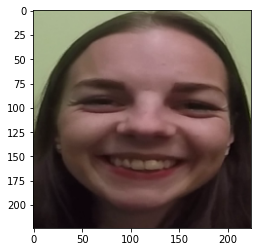

In [23]:
idx = 39
img = anchor_images[idx]

plt.imshow(img.numpy().transpose((1,2,0)), cmap = 'gray')
# img = torch.from_numpy(img).permute(2,0,1)/255.0
model.eval()
with torch.no_grad():
  img = img.to(device)
  img_enc = model(img.unsqueeze(0))
  img_enc = img_enc.detach().cpu().numpy()
  print(anc_img_names[idx])

In [24]:
def euclidean_distance(img_enc,anc_enc_arr):
  dist = np.sqrt(np.dot(img_enc-anc_enc_arr, (img_enc - anc_enc_arr).T))
  return dist
from scipy import spatial

In [25]:
anc_enc_arr = df_enc.iloc[:,1:].to_numpy()
anc_img_names = df_enc["Anchor"]
anc_name = anc_img_names[idx]

In [26]:
distance = []
method = "euclidean"
for i in range(anc_enc_arr.shape[0]):
  if method == "euclidean":
    dist=euclidean_distance(img_enc, anc_enc_arr[i:i+1,:])
  elif method == "cosine":
    dist = cosine_distance(img_enc, anc_enc_arr[i:i+1,:])
  
  distance = np.append(distance,dist)

In [27]:
closest_idx = np.argsort(distance)

In [28]:
import networkx as nx 
from skimage import io
import re
import matplotlib.pyplot as plt

def plot_closest_imgs(anchor_images, anc_img_names, closest_idxs, distance, no_of_closest = 10):

    G=nx.Graph()

    # S_name = [img_path.split('\\')[-1]]


    # for s in range(no_of_closest):
    #     S_name.append(anc_img_names.iloc[closest_idxs[s]].split('\\')[-1])
    
    subject = re.split('([0-9]+)',anc_img_names.iloc[closest_idx[0]])[3]
    print(subject)
    #anchor case
    image = anchor_images[closest_idxs[0]].permute(1,2,0)
    G.add_node(0,image = image)  
    # for i in range(no_of_closest + 1):
    #     image = anchor_images[closest_idxs[i]].permute(1,2,0)
    #     G.add_node(i,image = image)
    
    #close images
    for j in range(1,no_of_closest + 1):
        
        image = anchor_images[closest_idxs[j]].permute(1,2,0)
        G.add_node(j,image = image)
        G.add_edge(0,j,weight=distance[closest_idxs[j-1]])
        

    pos=nx.kamada_kawai_layout(G)

    fig=plt.figure(figsize=(20,20))
    ax=plt.subplot(111)
    ax.set_aspect('equal')
    nx.draw_networkx_edges(G,pos,ax=ax)

    plt.xlim(-1.5,1.5)
    plt.ylim(-1.5,1.5)

    trans=ax.transData.transform
    trans2=fig.transFigure.inverted().transform

    piesize=0.09 # this is the image size
    p2=piesize/2.0
    # print(piesize,p2)
    for n in G:
        xx,yy=trans(pos[n]) # figure coordinates
        xa,ya=trans2((xx,yy)) # axes coordinates
        a = plt.axes([xa-p2,ya-p2, piesize, piesize])
        a.set_aspect('equal')
        # print(G.nodes[n]['image'])
        a.imshow(G.nodes[n]['image'])
        a.set_title(anc_img_names.iloc[closest_idxs[n]].split('\\')[-1])
        a.axis('off')
    ax.axis('off')
    plt.show()

In [29]:
anc_img_names[closest_idx[0]]

'C:\\Users\\luca9\\Desktop\\Thesis\\Code\\Output\\Fake-Happy\\4S2N2H.k50'

4


c:\Users\luca9\miniconda3\envs\ml\lib\site-packages\networkx\drawing\layout.py:727: RuntimeWarning: divide by zero encountered in true_divide
  costargs = (np, 1 / (dist_mtx + np.eye(dist_mtx.shape[0]) * 1e-3), meanwt, dim)


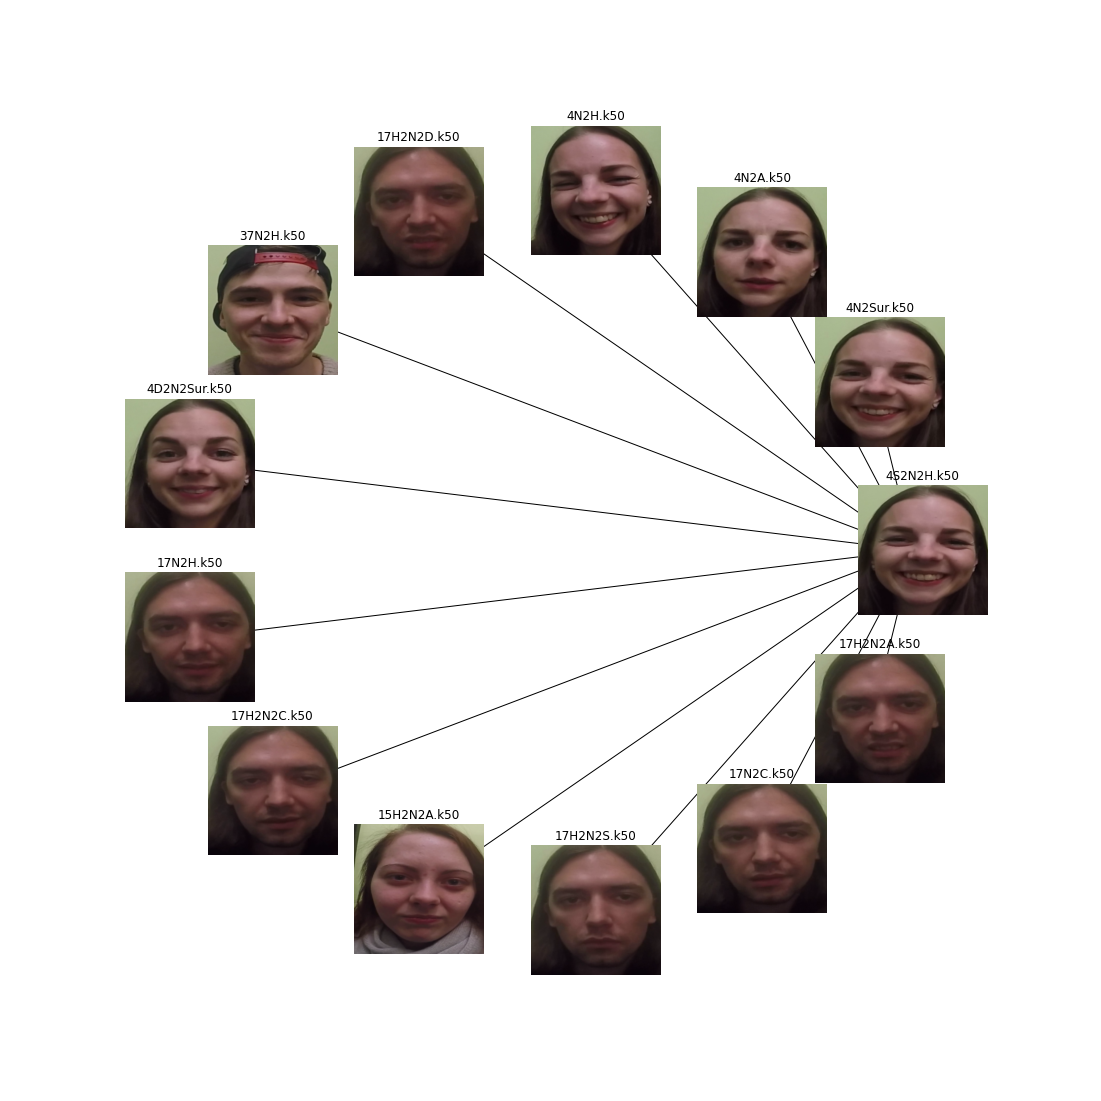

In [30]:
plot_closest_imgs(anchor_images, anc_img_names, closest_idx[:], distance, no_of_closest = 12);